In [118]:
# 環境によって処理を変えるためのもの
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')
if IN_KAGGLE or IN_COLAB:
    !pip install setuptools==57.4.0 -q
    !pip install xfeat -q

IN_COLAB:False, IN_KAGGLE:False, LOCAL:True


In [123]:
import sys
import pickle
sys.path.append('../')
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

import category_encoders as ce
from xfeat import *

# from scripts.base import Feature, get_arguments, generate_features
# Feature.dir = "F:/Kaggle/ventilator-pressure-prediction/data/input/features"
if IN_KAGGLE:
    INPUT_DIR = Path('../input/my-private/')
    OUTPUT_DIR = Path('./')
    FEAT_DIR = Path('./')
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/Ventilator Pressure/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/sig_sony/data/input/")
    OUTPUT_DIR = Path("F:/Kaggle/sig_sony/data/output/")
    FEAT_DIR = Path("F:/Kaggle/sig_sony/data/input/features/")

In [124]:
"""対数変換"""
# df_train['pm25_mid_log'] = np.log(df_train['pm25_mid'] + 1)
def get_train_test():
    _train = pd.read_csv(INPUT_DIR / "train.csv")
    _test = pd.read_csv(INPUT_DIR / "test.csv")
    return _train, _test

def load_datasets(feats):
    dfs = [pd.read_feather(FEAT_DIR / f'{f}_train.ftr') for f in feats]
    X_train = pd.concat(dfs, axis=1)
    dfs = [pd.read_feather(FEAT_DIR / f'{f}_test.ftr') for f in feats]
    X_test = pd.concat(dfs, axis=1)
    return X_train, X_test
def save_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def load_pickle(filename):
    with open(filename, mode='rb') as f:
        p = pickle.load(f)
    return p 

class CFG:
    seed = 1992
    target_col = 'pm25_mid'
    n_fold = 5
#     trn_fold = [0]
    trn_fold = [0,1,2,3,4]
    # COL
    cate_cols = []
    cont_cols = []
    feature_cols = []

### PCA UMAP

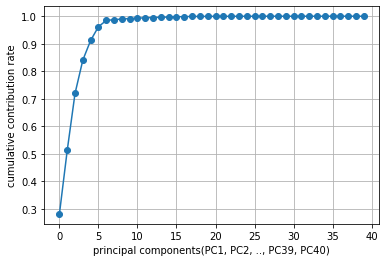

In [125]:
# PCA
df_train, df_test = get_train_test()
cont_cols = [col for col in df_train.columns if pd.api.types.is_numeric_dtype(df_train[col])]
for col in ['id','pm25_mid']:
    cont_cols.remove(col)

pca = PCA(n_components=40, random_state=0)
x_embedded = pca.fit_transform(df_train[cont_cols])
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel("principal components(PC1, PC2, .., PC39, PC40)")
plt.ylabel("cumulative contribution rate")
plt.grid()
plt.show()
# 6次元でよさそう

Wall time: 2.13 s


<AxesSubplot:>

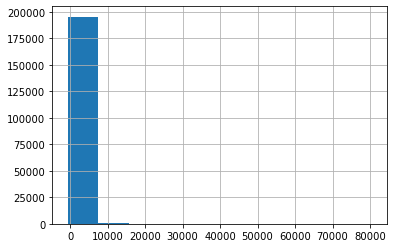

In [127]:
%%time
n_dim = 6
df_train, df_test = get_train_test()
len_train, len_test = len(df_train), len(df_test) 
df = pd.concat([df_train,df_test])

pca = PCA(n_components=n_dim, random_state=0)
x_embedded = pca.fit_transform(df[cont_cols])
df = pd.DataFrame(x_embedded).add_prefix('PCA')
# """戻す"""
df_train = df[:len_train].reset_index(drop=True)
df_test = df[len_train:].reset_index(drop=True)

# 保存
COL_PCA = df.columns.to_list()
d = dict(train=df_train[COL_PCA],test=df_test[COL_PCA],cate_cols=[],cont_cols=COL_PCA)
save_pickle(FEAT_DIR / 'PCA.pkl', d)
df_train.PCA0.hist()

Wall time: 4min 32s


<AxesSubplot:>

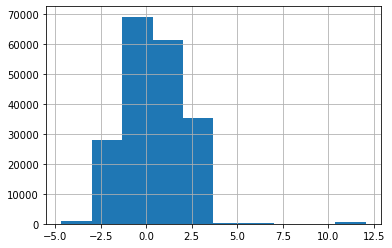

In [129]:
%%time
# UMAP
import umap
n_dim = 6
df_train, df_test = get_train_test()
len_train, len_test = len(df_train), len(df_test) 
df = pd.concat([df_train,df_test])
cont_cols = [col for col in df_train.columns if pd.api.types.is_numeric_dtype(df_train[col])]
for col in ['id','pm25_mid']:
    cont_cols.remove(col)
    
# 次元削減する
mapper = umap.UMAP(n_components=n_dim, random_state=29)
x_embedded = mapper.fit_transform(df[cont_cols])
df = pd.DataFrame(x_embedded).add_prefix('UMAP')

# """戻す"""
df_train = df[:len_train].reset_index(drop=True)
df_test = df[len_train:].reset_index(drop=True)

# 保存
COL_UMAP = df.columns.to_list()
d = dict(train=df_train[COL_UMAP],test=df_test[COL_UMAP],cate_cols=[],cont_cols=COL_UMAP)
save_pickle(FEAT_DIR / 'UMAP.pkl', d)
df_train.UMAP0.hist()

In [48]:
# Category Encodeing
def category_encoding(oe_columns: list, train: pd.DataFrame, test: pd.DataFrame = None):
    """trainのみでも使える"""
    OE_COLS = ['OE_' + col for col in oe_columns]
    ce_oe = ce.OrdinalEncoder(cols=oe_columns, handle_missing='return_nan')
    train[OE_COLS] = ce_oe.fit_transform(train[oe_columns])
    if test is not None:
        test[OE_COLS] = ce_oe.transform(test[oe_columns])
    return OE_COLS, train, test

# target encoding
def target_encoding(re_columns: list, target: str, train: pd.DataFrame, test: pd.DataFrame = None):
    """trainのみでも使える"""
    RE_COLS = [col + '_re' for col in re_columns]
    target_encoder = TargetEncoder(input_cols=re_columns,
                                   target_col=[target],
                                   fold=KFold(n_splits=5, shuffle=True, random_state=29),
                                   output_suffix="_re")
    train = target_encoder.fit_transform(train)
    if test is not None:
        test = target_encoder.transform(test)

    return RE_COLS, train, test

### [OE,Country_TE]

In [49]:
df_train, df_test = get_train_test()
"""
category encoding
"""
len_train, len_test = len(df_train), len(df_test) 
df = pd.concat([df_train,df_test])
df['Country_year']           = df['Country'] + '_y' + df['year'].astype('str')
df['Country_year_month']     = df['Country'] + '_y' + df['year'].astype('str')  +'_m' +  df['month'].astype('str')
df['Country_month']          = df['Country'] + '_m' + df['month'].astype('str')
df['Country_month_day']      = df['Country'] + '_m' + df['month'].astype('str') + '_d' + df['day'].astype('str')
df['Country_year_month_day'] = df['Country'] + '_y' + df['year'].astype('str')  + '_m' +  df['month'].astype('str') + '_d' + df['day'].astype('str')
df['City_year']           = df['City'] + '_y' + df['year'].astype('str')
df['City_year_month']     = df['City'] + '_y' + df['year'].astype('str')  +'_m' +  df['month'].astype('str')
df['City_month']          = df['City'] + '_m' + df['month'].astype('str')
df['City_month_day']      = df['City'] + '_m' + df['month'].astype('str') + '_d' + df['day'].astype('str')
df['City_year_month_day'] = df['City'] + '_y' + df['year'].astype('str')  + '_m' +  df['month'].astype('str') + '_d' + df['day'].astype('str')

OE_COLS, df, _ = category_encoding(['Country','Country_year','Country_year_month'], df)
"""戻す"""
df_train = df[:len_train]
df_test = df[len_train:]

CFG.feature_cols += OE_COLS
assert len_train == len(df_train) and len_test == len(df_test)

# 保存
d = dict(train=df_train[OE_COLS],test=df_test[OE_COLS],cate_cols=OE_COLS,cont_cols=[])
# save_pickle(FEAT_DIR / 'OE.pkl', d)

"""
target encoding
"""
# 国ごと
COL_LE, df_train, df_test = target_encoding(['Country','Country_year','Country_year_month','Country_month','Country_month_day','Country_year_month_day'], 'pm25_mid', df_train, df_test)
CFG.feature_cols += COL_LE

# 保存
d = dict(train=df_train[COL_LE],test=df_test[COL_LE],cate_cols=[],cont_cols=COL_LE)
# save_pickle(FEAT_DIR / 'Country_TE.pkl', d)

D:\python\Anaconda3\lib\site-packages\xfeat\cat_encoder\_target_encoder.py:187: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(input_df[self._target_col], warn=True)


In [ ]:
# """
# カウント特徴量を集約 本番でやるやるつ
# """
# col_cnt = [s for s in CFG.feature_cols if 'cnt' in s]
# df_train["cnt_mean"] = df_train[col_cnt].mean(axis=1)
# df_test["cnt_mean"] = df_test[col_cnt].mean(axis=1)
# CFG.feature_cols +=["cnt_mean"]
# # 各成分の測定回数列は削除しておく
# CFG.feature_cols = [col for col in CFG.feature_cols if col not in col_cnt]

In [52]:
# minとmaxの差の特徴量
# ============================================
df_train, df_test = get_train_test()
len_train, len_test = len(df_train), len(df_test) 
df = pd.concat([df_train,df_test])
bussitsu = ['co','o3','so2','no2','temperature','humidity','pressure','ws','dew']
col = []
for b in bussitsu:
    df[f'{b}_min_max_diff'] = df[f'{b}_max'] - df[f'{b}_min']
    col.append(f'{b}_min_max_diff')
"""戻す"""
df_train = df[:len_train]
df_test = df[len_train:]

CFG.feature_cols += col
assert len_train == len(df_train) and len_test == len(df_test)
# 保存
d = dict(train=df_train[col],test=df_test[col],cate_cols=[],cont_cols=col)
# save_pickle(FEAT_DIR / 'min_max_diff.pkl', d)
col

['co_min_max_diff',
 'o3_min_max_diff',
 'so2_min_max_diff',
 'no2_min_max_diff',
 'temperature_min_max_diff',
 'humidity_min_max_diff',
 'pressure_min_max_diff',
 'ws_min_max_diff',
 'dew_min_max_diff']

## preprocess
### near city master

In [75]:
# [near1-4]
# ============================================
train, test = get_train_test()
df_city = train[['City','lat','lon']].drop_duplicates().reset_index(drop=True).reset_index() # knn用にindexをもっておく
df_city_test = test[['City','lat','lon']].drop_duplicates().reset_index(drop=True)
df_city.to_csv(FEAT_DIR / 'city.csv', index=False)
dict_city = df_city['City'].to_dict()
display(df_city.head())

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(df_city[['lat','lon']], df_city[['City']])
dists, nears = neigh.kneighbors(df_city[['lat','lon']], return_distance=True)
dists_test, nears_test = neigh.kneighbors(df_city_test[['lat','lon']], return_distance=True)

df_city = pd.concat([df_city,
                     pd.DataFrame(dists).rename(columns={0:'dists0',1:'dists1',2:'dists2',3:'dists3',4:'dists4'}),
                     pd.DataFrame(nears).rename(columns={0:'nears0',1:'nears1',2:'nears2',3:'nears3',4:'nears4'})],axis=1)
df_city_test = pd.concat([df_city_test,
                          pd.DataFrame(dists_test).rename(columns={0:'dists1',1:'dists2',2:'dists3',3:'dists4',4:'dists5'}),
                          pd.DataFrame(nears_test).rename(columns={0:'nears1',1:'nears2',2:'nears3',3:'nears4',4:'nears5'})],axis=1)
# フォーマットをそろえる
df_city = df_city.drop(columns=['dists0','nears0'])
df_city_test = df_city_test.drop(columns=['dists5','nears5'])

# display(df_city.head())
# display(df_city_test.head())

df_near_city_master = pd.concat([df_city,df_city_test]).reset_index(drop=True)
# df_near_city_master.to_csv(INPUT_DIR / 'near_city_master.csv', index=False)

# 保存
train = train.merge(df_near_city_master,on='City',how='left')
test = test.merge(df_near_city_master,on='City',how='left')
for i in [1,2,3,4]:
    col = [f'nears{i}', f'dists{i}']
    d = dict(train=train[col],test=test[col],cate_cols=[col[0]],cont_cols=[col[1]])
#     save_pickle(FEAT_DIR / f'near_city{i}.pkl', d)

,index,City,lat,lon
0,0,Brisbane,-27.46794,153.02809
1,1,Darwin,-12.46113,130.84185
2,2,Melbourne,-37.81400,144.96332
3,3,Newcastle,-32.92953,151.78010
4,4,Perth,-31.95224,115.86140


,index,City,lat,lon,dists1,dists2,dists3,dists4,nears1,nears2,nears3,nears4
0,0,Brisbane,-27.46794,153.02809,5.602361,7.276226,13.117983,26.784951,3,5,2,1
1,1,Darwin,-12.46113,130.84185,24.582865,26.784951,29.020405,29.280808,4,0,2,3
2,2,Melbourne,-37.81400,144.96332,6.830706,8.386092,13.117983,29.020405,5,3,0,1
3,3,Newcastle,-32.92953,151.78010,1.737696,5.602361,8.386092,29.280808,5,0,2,1
4,4,Perth,-31.95224,115.86140,24.582865,29.686394,35.119142,35.931993,1,2,5,3


,City,lat,lon,dists1,dists2,dists3,dists4,nears1,nears2,nears3,nears4
0,Adelaide,-34.92866,138.59863,6.988166,12.305173,13.332204,16.244127,2,5,3,0
1,Sydney,-33.86785,151.20732,0.638606,1.099328,6.653875,7.386449,5,3,0,2
2,Brussels,50.85045,4.34878,0.373584,0.449398,0.662860,1.237829,6,7,222,8
3,Sarajevo,43.84864,18.35644,0.573911,0.756505,2.039699,2.227405,220,238,210,61
4,São José dos Campos,-23.17944,-45.88694,0.834700,6.242818,23.048106,27.394619,9,10,12,13


In [54]:
# [agg_main_mean,diff_mean_City_month]
# =========================================
df_train, df_test = get_train_test()
len_train, len_test = len(df_train),len(df_test) 
df = pd.concat([df_train,df_test])#結合
df['Country_year']           = df['Country'] + '_y' + df['year'].astype('str')
df['Country_year_month']     = df['Country'] + '_y' + df['year'].astype('str')  +'_m' +  df['month'].astype('str')
df['Country_month']          = df['Country'] + '_m' + df['month'].astype('str')
df['Country_month_day']      = df['Country'] + '_m' + df['month'].astype('str') + '_d' + df['day'].astype('str')
df['Country_year_month_day'] = df['Country'] + '_y' + df['year'].astype('str')  + '_m' +  df['month'].astype('str') + '_d' + df['day'].astype('str')
df['City_year']           = df['City'] + '_y' + df['year'].astype('str')
df['City_year_month']     = df['City'] + '_y' + df['year'].astype('str')  +'_m' +  df['month'].astype('str')
df['City_month']          = df['City'] + '_m' + df['month'].astype('str')
df['City_month_day']      = df['City'] + '_m' + df['month'].astype('str') + '_d' + df['day'].astype('str')
df['City_year_month_day'] = df['City'] + '_y' + df['year'].astype('str')  + '_m' +  df['month'].astype('str') + '_d' + df['day'].astype('str')

"""aggregation"""
col = []
for g_key in ['Country', 'Country_year','Country_year_month','Country_month','City','City_year','City_year_month','City_month']:
    df, aggregated_cols = aggregation(df,
                                      group_key=g_key,
                                      group_values=['co_mid', 'co_max','no2_mid','so2_mid','o3_mid', 'ws_mid', 'temperature_mid'],# group_keyごとのgroup_valuesのagg
                                      agg_methods=['mean'],#, 'max', 'min', 'std'
                                     )
    CFG.feature_cols += aggregated_cols
    col += aggregated_cols

# 平均とのdiff
diff_col = []
for c in ['co_mid', 'co_max','no2_mid','so2_mid','o3_mid', 'ws_mid', 'temperature_mid']:
    df[f'diff_mean_{c}_City_month'] = df[c] - df[f'agg_mean_{c}_grpby_City_month']
    CFG.feature_cols += [f'diff_mean_{c}_City_month']
    diff_col += [f'diff_mean_{c}_City_month']


"""戻す"""
df_train = df[:len_train]
df_test = df[len_train:]
assert len_train==len(df_train), len_test==len(df_test)
# Save
d = dict(train=df_train[col],test=df_test[col],cate_cols=[],cont_cols=col)
# save_pickle(FEAT_DIR / f'agg_main_mean.pkl', d)

# Save
# City,月毎の平均とその日の値の差分
d = dict(train=df_train[diff_col],test=df_test[diff_col],cate_cols=[],cont_cols=diff_col)
# save_pickle(FEAT_DIR / f'diff_mean_City_month.pkl', d)

## filled gapp data

- すべてのCityに対してすべての日付のレコードを作る

In [57]:
train, test = get_train_test()
print(train.shape)
train["timestamp"] = pd.to_datetime(train[["year", "month", "day"]])
test["timestamp"] = pd.to_datetime(test[["year", "month", "day"]])
# Insert empty records to fill missing observations
COLS_CC = ["Country", "City"]

def fill_date_gapps(df_feat, ts_start='2019-01-01', ts_end='2021-12-31'):
    dt_idx = pd.date_range(ts_start, ts_end, freq='d')
    df_filled = df_feat.set_index("timestamp").pipe(
        lambda df: df.groupby(COLS_CC).apply(lambda df: df.reindex(dt_idx))
    ).pipe(
        lambda df: df.reset_index(level=2)
    ).pipe(
        lambda df: df.rename({"level_2": "timestamp"}, axis=1)
    ).pipe(
        lambda df: df.drop(COLS_CC, axis=1)
    ).pipe(
        lambda df: df.reset_index()
    )
    return df_filled

df_filled_train = fill_date_gapps(train)
df_filled_test = fill_date_gapps(test)
print(df_filled_train.shape,df_filled_test.shape)
df_filled_train.to_csv(FEAT_DIR / 'filled_train.csv', index=False)
df_filled_test.to_csv(FEAT_DIR  / 'filled_test.csv', index=False)

(195941, 54)
(261944, 55) (69048, 54)


In [142]:
# self lag
# =========================================

from tqdm.notebook import tqdm

def create_lag_feature(lag:int):
    train, test = get_train_test()
    len_train, len_test = len(train),len(test) 
    df = pd.concat([train,test])#結合
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day"]])
    
    df_filled_train = pd.read_csv(FEAT_DIR / 'filled_train.csv')
    df_filled_test = pd.read_csv(FEAT_DIR / 'filled_test.csv')
    len_filled_train, len_filled_test = len(df_filled_train),len(df_filled_test) 
    df_filled = pd.concat([df_filled_train,df_filled_test])#結合

    cols = []
    bussitu = ['co_mid', 'co_max','no2_mid','so2_mid','o3_mid', 'ws_mid', 'temperature_mid']
    for col in bussitu:
        df_filled[f'{col}_lag{lag}'] = df_filled.groupby('City')[col].shift(lag)
#         df[f'{col}_diff1'] = df[col] - df[f'{col}_lag1']
#         cols +=[f'{col}_lag1',f'{col}_diff1']
        cols.append(f'{col}_lag{lag}')
    df_filled = df_filled[['City', 'timestamp'] + cols]
    
    # マージ
    df["timestamp"] = df["timestamp"].astype(str)
    df_filled["timestamp"] = df_filled["timestamp"].astype(str)
    df = pd.merge(df, df_filled,on=['City', 'timestamp'],how='left')
    train = df[:len_train].reset_index(drop=True)
    test = df[len_train:].reset_index(drop=True)
    assert len_train == len(train) and len_test == len(test)
    return train,test,cols

for lag in tqdm([-14,-7,-5,-4,-3,-2,-1,1,2,3,4,5,7,14]):#
    train, test, cols = create_lag_feature(lag)
    d = dict(train=train[cols],test=test[cols],cate_cols=[],cont_cols=cols)
    save_pickle(FEAT_DIR / f'lag{lag}.pkl', d)
# test.to_csv(INPUT_DIR / 'rag_test.csv', index=False)

  0%|          | 0/14 [00:00<?, ?it/s]

In [114]:
def create_rolling_feature(n_rolling:int, _agg:str):
    train, test = get_train_test()
    len_train, len_test = len(train),len(test) 
    df = pd.concat([train,test])#結合
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day"]])

    df_filled_train = pd.read_csv(FEAT_DIR / 'filled_train.csv')
    df_filled_test = pd.read_csv(FEAT_DIR / 'filled_test.csv')
    len_filled_train, len_filled_test = len(df_filled_train),len(df_filled_test) 
    df_filled = pd.concat([df_filled_train,df_filled_test])#結合

    cols = []
    bussitu = ['co_mid', 'co_max','no2_mid','so2_mid','o3_mid', 'ws_mid', 'temperature_mid']
    for col in bussitu:
        df_filled[f'{col}_rolling_{_agg}_{n_rolling}'] = df_filled.groupby('City')[col].rolling(n_rolling).agg([_agg]).reset_index(drop=True)
        cols.append(f'{col}_rolling_{_agg}_{n_rolling}')
    df_filled = df_filled[['City', 'timestamp'] + cols]

    # マージ
    df["timestamp"] = df["timestamp"].astype(str)
    df_filled["timestamp"] = df_filled["timestamp"].astype(str)
    df = pd.merge(df, df_filled,on=['City', 'timestamp'],how='left')
    train = df[:len_train].reset_index(drop=True)
    test = df[len_train:].reset_index(drop=True)
    assert len_train == len(train) and len_test == len(test)
    return train, test, cols

# for lag in tqdm([-5,-4,-3,-2,-1,1,2,3,4,5]):#
#     train, test, cols = create_lag_feature(lag)
#     d = dict(train=train[cols],test=test[cols],cate_cols=[],cont_cols=cols)
#     save_pickle(FEAT_DIR / f'lag{lag}.pkl', d)
# test.to_csv(INPUT_DIR / 'rag_test.csv', index=False)
for i in tqdm([2,4,10]):
    for j in ['mean', 'max', 'min', 'std']:
        train, test, cols = create_rolling_feature(n_rolling=i, _agg=j)
        d = dict(train=train[cols],test=test[cols],cate_cols=[],cont_cols=cols)
        save_pickle(FEAT_DIR / f'rolling_{j}_{i}.pkl', d)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# """近い都市とその距離"""
# KNN_COL = ['dists1','dists2','dists3','nears1','nears2','nears3']

# df_city = df_train[['City','lat','lon']].drop_duplicates().reset_index(drop=True).reset_index() # knn用にindexをもっておく
# df_city_test = df_test[['City','lat','lon']].drop_duplicates().reset_index(drop=True)

# # knn
# neigh = KNeighborsRegressor(n_neighbors=5)
# neigh.fit(df_city[['lat','lon']], df_city[['City']])
# dists, nears = neigh.kneighbors(df_city[['lat','lon']], return_distance=True)
# dists_test, nears_test = neigh.kneighbors(df_city_test[['lat','lon']], return_distance=True)

# df_city = pd.concat([df_city,
#                      pd.DataFrame(dists).rename(columns={0:'dists0',1:'dists1',2:'dists2',3:'dists3',4:'dists4'}),
#                      pd.DataFrame(nears).rename(columns={0:'nears0',1:'nears1',2:'nears2',3:'nears3',4:'nears4'})],axis=1)
# df_city_test = pd.concat([df_city_test,
#                           pd.DataFrame(dists_test).rename(columns={0:'dists1',1:'dists2',2:'dists3',3:'dists4',4:'dists5'}),
#                           pd.DataFrame(nears_test).rename(columns={0:'nears1',1:'nears2',2:'nears3',3:'nears4',4:'nears5'})],axis=1)
# display(df_city.head())
# display(df_city_test.head())

# df_train = pd.merge(df_train, df_city[['City'] + KNN_COL],on='City',how='left')
# df_test = pd.merge(df_test, df_city_test[['City'] + KNN_COL],on='City',how='left')
# CFG.feature_cols += KNN_COL

In [78]:
# # 都市毎のターゲットエンコード
# df_city = pd.read_csv(FEAT_DIR / 'city.csv')
# display(df_city.head())
# df_train, df_test = get_train_test()
# df = df_train[['City','year','month','pm25_mid']].copy()
# df['City_year'] = df['City'] + df['year'].astype('str')
# df['City_year_month'] = df['City'] + df['year'].astype('str')+ df['month'].astype('str')
# df['City_month'] = df['City'] + df['month'].astype('str')
# df = pd.merge(df, 
#               df.groupby('City').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_re'}),
#               on='City',how='left')
# df = pd.merge(df, 
#               df.groupby('City_year').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_year_re'}),
#               on='City_year',how='left')
# df = pd.merge(df, 
#               df.groupby('City_year_month').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_year_month_re'}),
#               on='City_year_month',how='left')
# df = pd.merge(df, 
#               df.groupby('City_month').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_month_re'}),
#               on='City_month',how='left')
# # Dayを使っていないため少し重複があるから削る
# print(df.shape)
# df = df.drop('pm25_mid', axis=1).drop_duplicates().reset_index(drop=True)
# print(df.shape)
# df = pd.merge(df, df_city[['index','City']], on='City',how='left')

# df

,index,City,lat,lon
0,0,Brisbane,-27.46794,153.02809
1,1,Darwin,-12.46113,130.84185
2,2,Melbourne,-37.81400,144.96332
3,3,Newcastle,-32.92953,151.78010
4,4,Perth,-31.95224,115.86140


(195941, 11)
(8213, 10)


,City,year,month,City_year,City_year_month,City_month,City_re,City_year_re,City_year_month_re,City_month_re,index
0,Brisbane,2019,1,Brisbane2019,Brisbane20191,Brisbane1,31.833212,30.636673,23.133500,33.808158,0
1,Darwin,2019,1,Darwin2019,Darwin20191,Darwin1,35.765797,36.699754,22.349633,28.573727,1
2,Melbourne,2019,1,Melbourne2019,Melbourne20191,Melbourne1,33.333343,31.692111,40.569548,43.757293,2
3,Newcastle,2019,1,Newcastle2019,Newcastle20191,Newcastle1,46.741010,40.732563,55.471935,71.098849,3
4,Perth,2019,1,Perth2019,Perth20191,Perth1,38.993941,35.169761,38.078800,45.720391,4
...,...,...,...,...,...,...,...,...,...,...,...
8208,Indianapolis,2021,12,Indianapolis2021,Indianapolis202112,Indianapolis12,41.400964,46.670957,38.540000,49.320207,204
8209,Huế,2021,12,Huế2021,Huế202112,Huế12,47.279338,50.553910,24.038000,45.062765,219
8210,Southend-on-Sea,2021,12,Southend-on-Sea2021,Southend-on-Sea202112,Southend-on-Sea12,46.106845,47.240913,46.862000,41.818333,227
8211,Puebla,2021,12,Puebla2021,Puebla202112,Puebla12,52.598220,45.102154,38.204333,47.238286,212


In [115]:
# もともと8213だったのを8604に
"""
全ての年、月、都市のdfを作る　3*12*239=8604
"""
df_city = pd.read_csv(FEAT_DIR / 'city.csv')
df_train, df_test = get_train_test()
year_month = df_train[['year','month']].drop_duplicates().reset_index()
cities =[]
for c in df_city["City"].to_numpy():
    _ = year_month.copy()
    _["City"] = c
    cities.append(_)
city_y_m = pd.concat(cities).reset_index(drop=True)
city_y_m['City_year'] = city_y_m['City'] + city_y_m['year'].astype('str')
city_y_m['City_year_month'] = city_y_m['City'] + city_y_m['year'].astype('str')+ city_y_m['month'].astype('str')
city_y_m['City_month'] = city_y_m['City'] + city_y_m['month'].astype('str')
display(city_y_m)
"""
都市に関して3つの切り口でターゲットエンコードエンコード
"""
df = df_train[['City','year','month','pm25_mid']].copy()
df['City_year'] = df['City'] + df['year'].astype('str')
df['City_year_month'] = df['City'] + df['year'].astype('str')+ df['month'].astype('str')
df['City_month'] = df['City'] + df['month'].astype('str')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_re'}),
                    on='City',how='left')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City_year').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_year_re'}),
                    on='City_year',how='left')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City_year_month').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_year_month_re'}),
                    on='City_year_month',how='left')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City_month').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_month_re'}),
                    on='City_month',how='left')
print(city_y_m.isnull().sum()) # nullがあるのはしょうがない

"""
train,testにマージして特徴量として保存
"""
df_train, df_test = get_train_test()
df = city_y_m.copy()
for i in [1,2,3,4]:
    print(f'===== create near{i}=====')
    d = load_pickle(FEAT_DIR / f"near_city{i}.pkl")
    _ = df_train[['year','month']].copy() # year month
    _ = pd.concat([_, d["train"][f"nears{i}"]],axis=1).rename(columns={f'nears{i}':'index'}) # year month nearcityindex
    _ = pd.merge(_, df_city[['index','City']],on='index',how='left')# year month nearcityindex, nearcityname
    _['City_year_month'] = _['City'] + _['year'].astype('str')+ _['month'].astype('str')
    _ = pd.merge(_,df[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']],on='City_year_month',how='left')
    # df_train = pd.concat([df_train,_[['City_re','City_year_re','City_year_month_re','City_month_re']]],axis=1)
    train = _[['City_re','City_year_re','City_year_month_re','City_month_re']].copy()
    train = train.add_prefix(f'near{i}_')
    print(train.isnull().sum())
    
    _ = df_test[['year','month']].copy()
    _ = pd.concat([_, d["test"][f"nears{i}"]],axis=1).rename(columns={f'nears{i}':'index'}) # year month nearcityindex
    _ = pd.merge(_, df_city[['index','City']],on='index',how='left')
    _['City_year_month'] = _['City'] + _['year'].astype('str')+ _['month'].astype('str')
    _ = pd.merge(_,df[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']],on='City_year_month',how='left')
    # test = _[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']]
    test = _[['City_re','City_year_re','City_year_month_re','City_month_re']].copy()
    test = test.add_prefix(f'near{i}_')

    cols = train.columns.to_list()
    d = dict(train=train[cols], test=test[cols], cate_cols=[], cont_cols=cols)
    save_pickle(FEAT_DIR / f'near{i}_City_LE.pkl', d)
    
    # CFG.feature_cols += ['City_re','City_year_re','City_year_month_re','City_month_re']

,index,year,month,City,City_year,City_year_month,City_month
0,0,2019,1,Brisbane,Brisbane2019,Brisbane20191,Brisbane1
1,5494,2019,2,Brisbane,Brisbane2019,Brisbane20192,Brisbane2
2,10091,2019,3,Brisbane,Brisbane2019,Brisbane20193,Brisbane3
3,16497,2019,4,Brisbane,Brisbane2019,Brisbane20194,Brisbane4
4,22347,2019,5,Brisbane,Brisbane2019,Brisbane20195,Brisbane5
...,...,...,...,...,...,...,...
8599,170912,2021,8,Tuzla,Tuzla2021,Tuzla20218,Tuzla8
8600,176177,2021,9,Tuzla,Tuzla2021,Tuzla20219,Tuzla9
8601,181388,2021,10,Tuzla,Tuzla2021,Tuzla202110,Tuzla10
8602,185713,2021,11,Tuzla,Tuzla2021,Tuzla202111,Tuzla11


index                   0
year                    0
month                   0
City                    0
City_year               0
City_year_month         0
City_month              0
City_re                 0
City_year_re          168
City_year_month_re    391
City_month_re         171
dtype: int64
===== create near1=====
near1_City_re                  0
near1_City_year_re          3223
near1_City_year_month_re    6956
near1_City_month_re         1826
dtype: int64
===== create near2=====
near2_City_re                  0
near2_City_year_re          2991
near2_City_year_month_re    6369
near2_City_month_re         3342
dtype: int64
===== create near3=====
near3_City_re                  0
near3_City_year_re          2693
near3_City_year_month_re    5718
near3_City_month_re         3053
dtype: int64
===== create near4=====
near4_City_re                  0
near4_City_year_re          1668
near4_City_year_month_re    5541
near4_City_month_re         2116
dtype: int64


In [140]:
train = []
test = []
for i in [1,2,3,4]:
    d = load_pickle(FEAT_DIR / f'near{i}_City_LE.pkl')
    train.append(d["train"])
    test.append(d["test"])
train = pd.concat(train,axis=1)
test = pd.concat(test,axis=1)


,near1_City_re,near1_City_year_re,near1_City_year_month_re,near1_City_month_re,near2_City_re,near2_City_year_re,near2_City_year_month_re,near2_City_month_re,near3_City_re,near3_City_year_re,near3_City_year_month_re,near3_City_month_re,near4_City_re,near4_City_year_re,near4_City_year_month_re,near4_City_month_re
0,46.741010,40.732563,55.471935,71.098849,40.979723,51.326245,65.045308,54.181153,33.333343,31.692111,40.569548,43.757293,35.765797,36.699754,22.349633,28.573727
1,38.993941,35.169761,38.078800,45.720391,31.833212,30.636673,23.133500,33.808158,33.333343,31.692111,40.569548,43.757293,46.741010,40.732563,55.471935,71.098849
2,40.979723,51.326245,65.045308,54.181153,46.741010,40.732563,55.471935,71.098849,31.833212,30.636673,23.133500,33.808158,35.765797,36.699754,22.349633,28.573727
3,40.979723,51.326245,65.045308,54.181153,31.833212,30.636673,23.133500,33.808158,33.333343,31.692111,40.569548,43.757293,35.765797,36.699754,22.349633,28.573727
4,35.765797,36.699754,22.349633,28.573727,33.333343,31.692111,40.569548,43.757293,40.979723,51.326245,65.045308,54.181153,46.741010,40.732563,55.471935,71.098849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,51.155581,62.810250,88.753000,104.433000,46.734572,46.784787,41.609583,42.298478,50.532566,48.265374,57.541722,47.777242,41.400964,46.670957,38.540000,49.320207
195937,54.177436,54.664942,58.052067,52.927403,27.797167,NaN,NaN,NaN,40.899248,44.618426,65.911200,42.716423,47.102635,46.381650,44.072750,52.074875
195938,41.400964,46.670957,38.540000,49.320207,43.173368,38.108050,NaN,41.983000,42.474391,40.682131,29.106417,37.004500,51.155581,62.810250,88.753000,104.433000
195939,45.604926,49.613449,58.656357,56.097736,72.939804,70.487303,95.521516,94.912484,52.391108,49.512771,59.955710,66.605516,47.279338,50.553910,24.038000,45.062765


### 都市ラベルエンコード　filldata version

In [116]:
# もともと8213だったのを8604に
"""
全ての年、月、都市のdfを作る　3*12*239=8604
"""
df_city = pd.read_csv(FEAT_DIR / 'city.csv')
df_train, df_test = get_train_test()
year_month = df_train[['year','month']].drop_duplicates().reset_index()
cities =[]
for c in df_city["City"].to_numpy():
    _ = year_month.copy()
    _["City"] = c
    cities.append(_)
city_y_m = pd.concat(cities).reset_index(drop=True)
city_y_m['City_year'] = city_y_m['City'] + city_y_m['year'].astype('str')
city_y_m['City_year_month'] = city_y_m['City'] + city_y_m['year'].astype('str')+ city_y_m['month'].astype('str')
city_y_m['City_month'] = city_y_m['City'] + city_y_m['month'].astype('str')
display(city_y_m)
"""
都市に関して3つの切り口でターゲットエンコードエンコード
"""
df = df_train[['City','year','month','pm25_mid']].copy()
df['City_year'] = df['City'] + df['year'].astype('str')
df['City_year_month'] = df['City'] + df['year'].astype('str')+ df['month'].astype('str')
df['City_month'] = df['City'] + df['month'].astype('str')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_re'}),
                    on='City',how='left')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City_year').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_year_re'}),
                    on='City_year',how='left')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City_year_month').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_year_month_re'}),
                    on='City_year_month',how='left')
city_y_m = pd.merge(city_y_m, 
                    df.groupby('City_month').agg({'pm25_mid':'mean'}).reset_index().rename(columns={'pm25_mid':'City_month_re'}),
                    on='City_month',how='left')
print(city_y_m.isnull().sum()) # nullがあるのはしょうがない

"""
fillna======================================================
"""
for i,v in enumerate(city_y_m.iloc[:,7:].to_numpy()):
    """
    ・全部nanならcity全部を入れる
    ・City_year_month,City_monthがなければCity_yearをいれる
    ・City_year,City_year_monthがなければCity_monthをいれる
    ・City_year_monthがなければCity_monthをいれる
    """
    if np.isnan(v[1]) and np.isnan(v[2]) and np.isnan(v[3]):
        v[1] = v[0]
        v[2] = v[0]
        v[3] = v[0]
    elif np.isnan(v[3]) and np.isnan(v[2]):
        v[2] = v[1]
        v[3] = v[1]
    elif np.isnan(v[1]) and np.isnan(v[2]):
        v[1] = v[3]
        v[2] = v[3]
    elif np.isnan(v[2]):
        v[2] = v[3]
    city_y_m.iloc[i,7:] = v
    
# ===============================================================
"""
train,testにマージして特徴量として保存
"""
df_train, df_test = get_train_test()
df = city_y_m.copy()
for i in [1,2,3,4]:
    print(f'===== create near{i}=====')
    d = load_pickle(FEAT_DIR / f"near_city{i}.pkl")
    _ = df_train[['year','month']].copy() # year month
    _ = pd.concat([_, d["train"][f"nears{i}"]],axis=1).rename(columns={f'nears{i}':'index'}) # year month nearcityindex
    _ = pd.merge(_, df_city[['index','City']],on='index',how='left')# year month nearcityindex, nearcityname
    _['City_year_month'] = _['City'] + _['year'].astype('str')+ _['month'].astype('str')
    _ = pd.merge(_,df[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']],on='City_year_month',how='left')
    # df_train = pd.concat([df_train,_[['City_re','City_year_re','City_year_month_re','City_month_re']]],axis=1)
    train = _[['City_re','City_year_re','City_year_month_re','City_month_re']].copy()
    train = train.add_prefix(f'near{i}_')
    print(train.isnull().sum())
    
    _ = df_test[['year','month']].copy()
    _ = pd.concat([_, d["test"][f"nears{i}"]],axis=1).rename(columns={f'nears{i}':'index'}) # year month nearcityindex
    _ = pd.merge(_, df_city[['index','City']],on='index',how='left')
    _['City_year_month'] = _['City'] + _['year'].astype('str')+ _['month'].astype('str')
    _ = pd.merge(_,df[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']],on='City_year_month',how='left')
    # test = _[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']]
    test = _[['City_re','City_year_re','City_year_month_re','City_month_re']].copy()
    test = test.add_prefix(f'near{i}_')

    cols = train.columns.to_list()
    d = dict(train=train[cols], test=test[cols], cate_cols=[], cont_cols=cols)
    save_pickle(FEAT_DIR / f'near{i}_City_LE_fillna.pkl', d)
    
    # CFG.feature_cols += ['City_re','City_year_re','City_year_month_re','City_month_re']

,index,year,month,City,City_year,City_year_month,City_month
0,0,2019,1,Brisbane,Brisbane2019,Brisbane20191,Brisbane1
1,5494,2019,2,Brisbane,Brisbane2019,Brisbane20192,Brisbane2
2,10091,2019,3,Brisbane,Brisbane2019,Brisbane20193,Brisbane3
3,16497,2019,4,Brisbane,Brisbane2019,Brisbane20194,Brisbane4
4,22347,2019,5,Brisbane,Brisbane2019,Brisbane20195,Brisbane5
...,...,...,...,...,...,...,...
8599,170912,2021,8,Tuzla,Tuzla2021,Tuzla20218,Tuzla8
8600,176177,2021,9,Tuzla,Tuzla2021,Tuzla20219,Tuzla9
8601,181388,2021,10,Tuzla,Tuzla2021,Tuzla202110,Tuzla10
8602,185713,2021,11,Tuzla,Tuzla2021,Tuzla202111,Tuzla11


index                   0
year                    0
month                   0
City                    0
City_year               0
City_year_month         0
City_month              0
City_re                 0
City_year_re          168
City_year_month_re    391
City_month_re         171
dtype: int64
===== create near1=====
near1_City_re               0
near1_City_year_re          0
near1_City_year_month_re    0
near1_City_month_re         0
dtype: int64
===== create near2=====
near2_City_re               0
near2_City_year_re          0
near2_City_year_month_re    0
near2_City_month_re         0
dtype: int64
===== create near3=====
near3_City_re               0
near3_City_year_re          0
near3_City_year_month_re    0
near3_City_month_re         0
dtype: int64
===== create near4=====
near4_City_re               0
near4_City_year_re          0
near4_City_year_month_re    0
near4_City_month_re         0
dtype: int64


In [97]:
# バグありバージョン
# df_train, df_test = get_train_test()
# for i in [1,2,3,4]:
#     d = load_pickle(FEAT_DIR / f"near_city{i}.pkl")
#     _ = df_train[['year','month']].copy() # year month
#     _ = pd.concat([_, d["train"][f"nears{i}"]],axis=1).rename(columns={f'nears{i}':'index'}) # year month nearcityindex
#     _ = pd.merge(_, df_city[['index','City']],on='index',how='left')# year month nearcityindex, nearcityname
#     _['City_year_month'] = _['City'] + _['year'].astype('str')+ _['month'].astype('str')
#     _ = pd.merge(_,df[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']],on='City_year_month',how='left')
#     # df_train = pd.concat([df_train,_[['City_re','City_year_re','City_year_month_re','City_month_re']]],axis=1)
#     train = _[['City_re','City_year_re','City_year_month_re','City_month_re']].copy()
#     train = train.add_prefix(f'near{i}_')
    
#     _ = df_test[['year','month']].copy()
#     _ = pd.concat([_, d["test"][f"nears{i}"]],axis=1).rename(columns={f'nears{i}':'index'}) # year month nearcityindex
#     _ = pd.merge(_, df_city[['index','City']],on='index',how='left')
#     _['City_year_month'] = _['City'] + _['year'].astype('str')+ _['month'].astype('str')
#     _ = pd.merge(_,df[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']],on='City_year_month',how='left')
#     # test = _[['City_year_month','City_re','City_year_re','City_year_month_re','City_month_re']]
#     test = _[['City_re','City_year_re','City_year_month_re','City_month_re']].copy()
#     test = test.add_prefix(f'near{i}_')

#     cols = train.columns.to_list()
#     d = dict(train=train[cols], test=test[cols], cate_cols=[], cont_cols=cols)
#     save_pickle(FEAT_DIR / f'near{i}_City_LE.pkl', d)
    
#     # CFG.feature_cols += ['City_re','City_year_re','City_year_month_re','City_month_re']

### [near1_City_label]近い距離の都市のラベルデータ
- train near都市のデータを引っ張ってくる為に使用
- Filleddataに近傍都市のデータをくっつけてラグとか作る
- 元のデータに左外部結合

In [130]:
cols = ["pm25_mid"] #引っ張ってくるカラム
for i in [1,2,3,4]:
    # データ取得
    Mcity = pd.read_csv(FEAT_DIR / 'city.csv')#index付与用
    Ftrain = pd.read_csv(FEAT_DIR / 'filled_train.csv',usecols=['City','timestamp'])
    Ftest = pd.read_csv(FEAT_DIR / 'filled_test.csv',usecols=['City','timestamp'])
    train,test = get_train_test()

    # timestamp作成
    train["timestamp"] = pd.to_datetime(train[["year", "month", "day"]])
    train["timestamp"] = train["timestamp"].astype(str)
    test["timestamp"] = pd.to_datetime(test[["year", "month", "day"]])
    test["timestamp"] = test["timestamp"].astype(str)
    # cityindex付与
    train = pd.merge(train,df_city[['index','City']],on='City',how='left')

    # i番目に近い都市のインデックスを結合
    Mcity = pd.read_csv('./near_city_master.csv')[["City",f"nears{i}"]]
    Ftrain = pd.merge(Ftrain,Mcity,on="City",how="left").rename(columns={f'nears{i}':'index'})
    Ftest = pd.merge(Ftest,Mcity,on="City",how="left").rename(columns={f'nears{i}':'index'})
    # 近傍都市のデータを結合
    Ftrain = pd.merge(Ftrain, train[['timestamp','index']+ cols], on=['timestamp','index'],how='left')
    Ftest = pd.merge(Ftest, train[['timestamp','index']+ cols], on=['timestamp','index'],how='left')
    # 特徴量作成
    Ftrain["pm25_mid_lag1"] = Ftrain.groupby('City')["pm25_mid"].shift(1)
    Ftrain["pm25_mid_lag-1"] = Ftrain.groupby('City')["pm25_mid"].shift(-1)
    Ftest["pm25_mid_lag1"] = Ftest.groupby('City')["pm25_mid"].shift(1)
    Ftest["pm25_mid_lag-1"] = Ftest.groupby('City')["pm25_mid"].shift(-1)
    train = pd.merge(train[['timestamp','City']],
                     Ftrain[["pm25_mid_lag1","pm25_mid_lag-1",'timestamp','City']+ cols],
                     on=['timestamp','City'],how='left').add_prefix(f'near{i}_')
    test = pd.merge(test[['timestamp','City']],
                    Ftest[["pm25_mid_lag1","pm25_mid_lag-1",'timestamp','City']+ cols],
                    on=['timestamp','City'],how='left').add_prefix(f'near{i}_')
    COLS = [f"near{i}_pm25_mid_lag1",f"near{i}_pm25_mid_lag-1", f"near{i}_pm25_mid"]
    d = dict(train=train[COLS], test=test[COLS], cate_cols=[], cont_cols=COLS)
    save_pickle(FEAT_DIR / f'near{i}_City_label.pkl', d)

### near1_City_main_feature

In [133]:
cols =  ['co_mid', 'co_max','no2_mid','so2_mid','o3_mid', 'ws_mid', 'temperature_mid'] #引っ張ってくるカラム
for i in [1,2,3,4]:
    # データ取得
    Mcity = pd.read_csv(FEAT_DIR / 'city.csv')#index付与用
    Ftrain = pd.read_csv(FEAT_DIR / 'filled_train.csv',usecols=['City','timestamp'])
    Ftest = pd.read_csv(FEAT_DIR / 'filled_test.csv',usecols=['City','timestamp'])
    train,test = get_train_test()

    # timestamp作成
    train["timestamp"] = pd.to_datetime(train[["year", "month", "day"]])
    train["timestamp"] = train["timestamp"].astype(str)
    test["timestamp"] = pd.to_datetime(test[["year", "month", "day"]])
    test["timestamp"] = test["timestamp"].astype(str)
    # cityindex付与
    train = pd.merge(train,df_city[['index','City']],on='City',how='left')

    # i番目に近い都市のインデックスを結合
    Mcity = pd.read_csv('./near_city_master.csv')[["City",f"nears{i}"]]
    Ftrain = pd.merge(Ftrain,Mcity,on="City",how="left").rename(columns={f'nears{i}':'index'})
    Ftest = pd.merge(Ftest,Mcity,on="City",how="left").rename(columns={f'nears{i}':'index'})
    # 近傍都市のデータを結合
    Ftrain = pd.merge(Ftrain, train[['timestamp','index']+ cols], on=['timestamp','index'],how='left')
    Ftest = pd.merge(Ftest, train[['timestamp','index']+ cols], on=['timestamp','index'],how='left')
    train = pd.merge(train[['timestamp','City']],Ftrain[['timestamp','City']+ cols],
                     on=['timestamp','City'],how='left').add_prefix(f'near{i}_')
    test = pd.merge(test[['timestamp','City']],Ftest[['timestamp','City']+ cols],
                    on=['timestamp','City'],how='left').add_prefix(f'near{i}_')
    COLS = [f"near{i}_co_mid",f"near{i}_co_max", f"near{i}_no2_mid",
            f"near{i}_so2_mid",f"near{i}_o3_mid", f"near{i}_ws_mid", f"near{i}_temperature_mid"]
    d = dict(train=train[COLS], test=test[COLS], cate_cols=[], cont_cols=COLS)
    save_pickle(FEAT_DIR / f'near{i}_City_main_feature.pkl', d)

### 1st stage特徴量

In [141]:
oof,sub = [], []
OUTPUT_DIR2 = Path("F:/Kaggle/sig_sony/data/output/")
# 1dcnn 21.47175128661955
# =====================================================================================
oof.append(pd.read_csv(OUTPUT_DIR2 / '1dcnn33/oof_31.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / '1dcnn33/oof_32.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / '1dcnn33/oof_34.csv',usecols=['pred']).to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / '1dcnn33/submission_31.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / '1dcnn33/submission_32.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / '1dcnn33/submission_34.csv', header=None, names=['id', 'pred']).pred.to_numpy())

# mlp 21.6572
# =====================================================================================
oof.append(pd.read_csv(OUTPUT_DIR2 / 'mlp14/oof_20.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'mlp14/oof_24.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'mlp14/oof_25.csv',usecols=['pred']).to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'mlp14/submission_20.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'mlp14/submission_24.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'mlp14/submission_25.csv', header=None, names=['id', 'pred']).pred.to_numpy())

# LightGBM regression 21.2952
# =====================================================================================
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp039/oof_12.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp039/oof_29.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp039/oof_821.csv',usecols=['pred']).to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp039/submission_12.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp039/submission_29.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp039/submission_821.csv', header=None, names=['id', 'pred']).pred.to_numpy())
21.120629705883758

# LightGBM tweedie 21.3348
# =====================================================================================
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp041/oof_5.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp041/oof_12.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp041/oof_28.csv',usecols=['pred']).to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp041/submission_5.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp041/submission_12.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp041/submission_28.csv', header=None, names=['id', 'pred']).pred.to_numpy())
21.07896231852814

# catboost 21.4412
# =====================================================================================
oof.append(pd.read_csv(OUTPUT_DIR2 / 'cat5/oof_11.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'cat5/oof_12.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'cat5/oof_13.csv',usecols=['pred']).to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'cat5/submission_11.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'cat5/submission_12.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'cat5/submission_13.csv', header=None, names=['id', 'pred']).pred.to_numpy())
21.083593870721522

# xgb 21.3414
# =====================================================================================
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp040/oof_20.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp040/oof_22.csv',usecols=['pred']).to_numpy())
oof.append(pd.read_csv(OUTPUT_DIR2 / 'exp040/oof_23.csv',usecols=['pred']).to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp040/submission_20.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp040/submission_22.csv', header=None, names=['id', 'pred']).pred.to_numpy())
sub.append(pd.read_csv(OUTPUT_DIR2 / 'exp040/submission_23.csv', header=None, names=['id', 'pred']).pred.to_numpy())

train = pd.DataFrame(np.squeeze(np.stack(oof,axis=1)))
test = pd.DataFrame(np.squeeze(np.stack(sub,axis=1)))
COLS = train.columns.to_list()

d = dict(train=train[COLS], test=test[COLS], cate_cols=[], cont_cols=COLS)
save_pickle(FEAT_DIR / f'1st_preds.pkl', d)